In [33]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras import models
from keras import layers
from keras import regularizers

from sklearn.metrics import accuracy_score

import re, string, random
import math
import random
from collections import defaultdict
from pprint import pprint
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import string


import numpy as np
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 213  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings

In [6]:
root = Path('../')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

In [7]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)


<strong><h1>Data Preparation</h1></strong>

In [13]:
#Reading and Cleaning Data
reviews = pd.read_csv(r"C:\Users\utkar\Desktop\Research Paper\amazon_reviews_sample.csv")
#df = df.reindex(np.random.permutation(df.index))  
#df = df[['text', 'airline_sentiment']]
#df.review = df.review.apply(remove_stopwords).apply(remove_mentions)
df = pd.DataFrame(reviews)
df.head()

,Unnamed: 0,score,review
0,0,1,Stuning even for the non-gamer: This sound tr...
1,1,1,The best soundtrack ever to anything.: I'm re...
2,2,1,Amazing!: This soundtrack is my favorite musi...
3,3,1,Excellent Soundtrack: I truly like this sound...
4,4,1,"Remember, Pull Your Jaw Off The Floor After H..."


In [14]:
stop = set(stopwords.words('english'))
def clean_document(doco):
    punctuation = string.punctuation
    punc_replace = ''.join([' ' for s in punctuation])
    doco_link_clean = re.sub(r'http\S+', '', doco)
    doco_clean_and = re.sub(r'&\S+', '', doco_link_clean)
    doco_clean_at = re.sub(r'@\S+', '', doco_clean_and)
    doco_clean = doco_clean_at.replace('-', ' ')
    doco_alphas = re.sub(r'\W +', ' ', doco_clean)
    trans_table = str.maketrans(punctuation, punc_replace)
    doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')])
    doco_clean = doco_clean.split(' ')
    p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
    doco_clean = [word.lower() for word in doco_clean if len(word) > 2]
    doco_clean = ([i for i in doco_clean if i not in stop])
    doco_clean = ([i for i in doco_clean if i.isalpha()]) # removing numeric
    #doco_clean = ([[word for word in item if word.isalpha()] for item in doco_clean])
#     doco_clean = [spell(word) for word in doco_clean]
#     p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    doco_clean = ([p.sub("", x).strip() for x in doco_clean])
#     doco_clean = ([spell(k) for k in doco_clean])
    return doco_clean

In [17]:
review_clean = [clean_document(doc) for doc in df['review']]
sentences = [' '.join(r) for r in review_clean]
df['cleantext']=sentences
df.tail(20)

,Unnamed: 0,score,review,cleantext
9980,9980,1,"Magic, on Blu Ray, starrring Anthony Hopkins ...",magic blu ray starrring anthony hopkins ann ma...
9981,9981,1,A ventriloquists nightmare: Magic is a timele...,ventriloquists nightmare magic timeless suspen...
9982,9982,0,great movie massacred by tape quality: One of...,great movie massacred tape quality one time fa...
9983,9983,1,Early Hopkins story still sends chills throug...,early hopkins story still sends chills viewers...
9984,9984,0,"The Only Dummy Is The Writer: ""Magic"" poses t...",dummy writer magic poses question whether vent...
9985,9985,1,"""He's NO Dummy. . ."": Viewing ""Magic"" is when...",dummy viewing magic first became aware anthony...
9986,9986,1,Amazingly suspenseful psychological thriller:...,amazingly suspenseful psychological thriller s...
9987,9987,1,A truly great horror movie: I saw this film l...,truly great horror movie saw film last night r...
9988,9988,1,Frightening movie with superb acting by Sir H...,frightening movie superb acting sir hopkins re...
9989,9989,1,classic: i got this for my dad. it is super c...,classic got dad super creepy worth watch watch...


<strong>Train-Test split</strong>

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.review, df.score, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 9000
# Test data samples: 1000


<strong>Converting words to numbers</strong>

In [36]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<strong>Creating word sequences of equal length</strong>
Before we can compute the word embeddings, we need to make sure the sequences are of equal length. In the example below, we truncate sequences to length MAX_LEN, or pad them with zeroes to achieve this. First, we'll have a look at the length of the (cleaned) tweets.

In [22]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    9000.000000
mean       80.399889
std        42.951278
min        15.000000
25%        44.000000
50%        72.000000
75%       110.000000
max       213.000000
Name: review, dtype: float64

Based on the figures above we will set MAX_LEN to 213. So this means we will not be truncating any words, only pad with zeros. This is to avoid to lose information as the tweets are rather short.

In [24]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [25]:
X_train_seq_trunc[10]  # Example of padded sequence

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

<strong>Converting the target classes to numbers</strong>

In [39]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

[0 1 0 ... 0 0 1]


<strong>Splitting off validation data</strong>

In [27]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (900, 213)


<strong><h1>Modelling</h1>
    Training Word Embeddings</strong>
    Keras provides an Embedding layer which helps us to train specific word embeddings based on our training data. It will convert the words in our vocabulary to multi-dimensional vectors.

In [78]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 213, 8)            80000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1704)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 3410      
Total params: 83,410
Trainable params: 83,410
Non-trainable params: 0
_________________________________________________________________


In [79]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

In [80]:
emb_history.history['accuracy'][-1]
#Validation Accuracy is 90.9% when using Deep Learning Sequential Word Embedding

0.9090123176574707

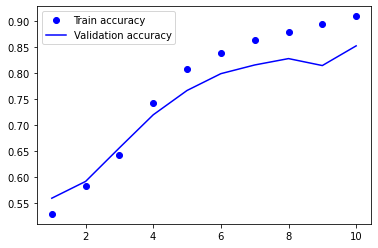

In [82]:
eval_metric(emb_history, 'accuracy')

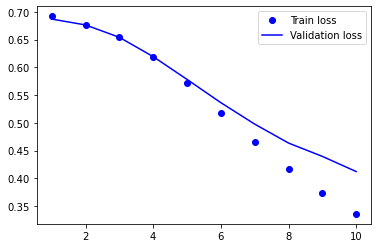

In [83]:
eval_metric(emb_history, 'loss')

By comparing training and validation accuracy and loss, we see that the model starts overfitting from epoch 5

In [84]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 7)

32/32 [==============================] - 0s 645us/step - loss: 0.3482 - accuracy: 0.8550


<strong>Test Accuracy of Sequential Word Embedding is 85.50%</strong>

NameError: name 'WNlemmatizer' is not defined